# Inter-subjects correlation (figure 1)

### Importing functions

In [1]:
import matplotlib as mpl
import h5py
import mne
import numpy as np
import scipy.stats as stats
import scipy
import pandas as pd
from os.path import join as pjoin
from itertools import product
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
import matplotlib.cm as cm
import random
import os
import pickle
import warnings 
import matplotlib
import seaborn as sns

#From the toolbox
import saving as sv
import avalanches as av
import Utils_FC as fc
from utils import *

warnings.simplefilter('ignore')

#Here the path to data 
path_results='C:/Users/matte/OneDrive/Documenti/matteo/sorciere_results/'
path_figures='C:/Users/matte/OneDrive/Documenti/matteo/sorciere_results/'
path='C:/Users/matte/OneDrive/Documenti/matteo/'

#colors for plotting 
col_s='#8CCC94'
col_m='#FCAC74'
col_r='#6CA4CC'

colors={}
colors['rest'] = col_r
colors['speech'] = col_s
colors['music'] = col_m

#Here uploading subject and sound list
sound_list=['rest','music','speech']

subject_list = sv.loading(path+'sorciere_utils/sublist')

cha_i=sv.loading(path+'sorciere_utils/channels_dic_H_non_H_left_right')



### Uploading data

In [2]:

#PARAMETERS

subject_list=subject_list
final_channels_without_H={}
final_channels_H={}
final_channels_all={}
dataused='all' #indicate if we want to load only heschl's gyrus or all the channels.

zdata={}

for isub, subject in enumerate(subject_list):
    
    zdata[subject]={}
    
    for sound in sound_list:
    
        ## Load the data from the HDF file
        with h5py.File(pjoin(path+'seeg_data_hgenv_down100_h5py/', subject + '_down100_seeg_preproc.hdf5'), 'r') as f:

            #data_music[subject]=f['music'][...]
            data_raw=f[sound][...]
            
            #Here we delete the time point of the rest that correspond to the end and beginning of the three sessions
            if sound=='rest':
                index_del=np.concatenate((np.arange(int(len(data_raw[0,:])/3)-200,int(len(data_raw[0,:])/3)+200),np.arange(int(len(data_raw[0,:])*2/3)-200,int(len(data_raw[0,:])*2/3)+200)))   
                data_raw=np.delete(data_raw, index_del, axis=1)

            data_raw=data_raw[:,100:-100]

        #Here we load the channels names
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        #Here we load the list of bad channels
        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:

            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
            #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]

        #Cleaning from artifacts
        #List of bad channels indices
        ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

        clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]

        clean= np.delete(data_raw, ch_i, axis=0)

        #dictionaries with subjects ad keys and channels names
        final_channels_without_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i in cha_i[subject]['H']]
        final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i not in cha_i[subject]['H']]
        final_channels_all[subject]=clean_chnames

        #The final channels that we used
        final_channels=clean_chnames

        #HERE WE CREATE THE DATA SET, THAT WE USE
        if dataused=='H':
            clean = np.delete(clean, cha_i[subject]['non_H'], axis=0)

        #only the channels not in the helsch gyrus
        elif dataused=='non_H':
            clean = np.delete(clean, cha_i[subject]['H'], axis=0)

        #zscore of the data
        zdata_art=stats.zscore(clean, axis=1)

        #the artifacts are substituted by 0
        zdata_=np.where(np.abs(zdata_art)>5, 0, zdata_art)

        #zscored computed again
        zdata[subject][sound]=stats.zscore(zdata_, axis=1)



Here we compute the activity profile of each participant.

In [3]:

ap={} #here the activity profile of each subject is stored

#data=sv.loading( path+"data_subject_sound_" + datatipe)
for subject in subject_list:
    ap[subject]={}
    avalanches={}
    
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata[subject]['rest'], 99)
    
    for sound in sound_list:
        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches[sound]=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=2)

        #the activity profile is computed, summing across regions.
        ap[subject][sound]=np.sum(avalanches[sound]['Zbin'].T, axis=0)
        

Here we create a matrix for each condition, whose lines are APs of different subjects

In [4]:
ap_matrix={} 
for sound in sound_list:
    ap_matrix[sound]=np.zeros((len(subject_list), len(ap[subject_list[0]][sound])))
    for isub, subject in enumerate(subject_list):
        ap_matrix[sound][isub,:]=ap[subject][sound]
    

Here the correlation matrices (subject x subject) are computed, using the Pearson correlation. Also using the Spearman correlation the results are significant

In [5]:
corr_matrix={}
for sound in sound_list:
    corr_matrix[sound]=np.corrcoef(ap_matrix[sound])  

#For saving the results
#sv.saving(corr_matrix, 'matrix_corr_'+dataused)

    

Here the correlation matrices are plotted.

rest


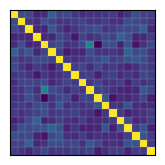

music


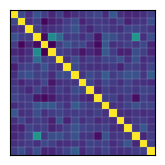

speech


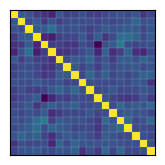

In [6]:
vm=0.2
cl='viridis'
colorbar=False

for sound in sound_list:
    
    a,b=0,0.1
    print(sound)
    plt.figure(figsize=(1.75,1.75))
    plt.imshow(corr_matrix[sound],cmap=cl,interpolation='nearest',vmax=vm,)
    for i in range(len(subject_list)):
        plt.axvline(i-0.5,linewidth=0.15,color='lightsteelblue')
        plt.axhline(i-0.5,linewidth=0.15,color='lightsteelblue')
    plt.yticks([])
    plt.xticks([])
    if sound=='rest' and colorbar==True:
        plt.colorbar(orientation = 'horizontal', shrink=1, aspect=5)
    plt.tight_layout()

    #saving the figure:
    plt.savefig(path_figures+'intersub_corr_matrix_AP_colorbar'+sound+'_'+dataused+'.png', dpi=600)

    plt.show()

### Here we compute the p value between the different correlation matrices

In [19]:
print('music vs rest')

print(stats.wilcoxon(corr_matrix['music'][np.triu_indices(19, k = 1)],corr_matrix['rest'][np.triu_indices(19, k = 1)]))

print('speech vs rest')
print(stats.wilcoxon(corr_matrix['speech'][np.triu_indices(19, k = 1)],corr_matrix['rest'][np.triu_indices(19, k = 1)]))

print('speech vs music')
print(stats.wilcoxon(corr_matrix['speech'][np.triu_indices(19, k = 1)],corr_matrix['music'][np.triu_indices(19, k = 1)]))

music vs rest
WilcoxonResult(statistic=4604.0, pvalue=2.2346957569150894e-05)
speech vs rest
WilcoxonResult(statistic=3450.0, pvalue=1.7444183410454156e-09)
speech vs music
WilcoxonResult(statistic=6211.0, pvalue=0.07816771084583302)


Surrogate data procedure

In [12]:
list_mean_corr={} #Here we store the result of each iteration

num_it=1000 

for sound in sound_list:
    list_mean_corr[sound]=[]

    for i in range(num_it):
        
        #Here the random shifting is performed.
        ap_shift=shifting_matrix(ap_matrix[sound])
        list_mean_corr[sound].append(np.mean(np.corrcoef(ap_shift)[np.triu_indices(19, k = 1)]))
    
sv.saving(list_mean_corr, path_results+"list_random_correlation_dict"+dataused)

In [7]:
list_mean_corr=sv.loading(path_results+"list_random_correlation_dict"+dataused)

### Plotting the results of intersubject correlation, comparison with the null model

rest


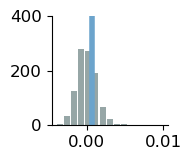

music


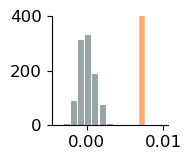

speech


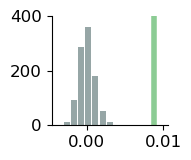

In [11]:
list_mean_corr=sv.loading(path_results+"list_random_correlation_dict"+dataused)

for sound in sound_list:

    #Here we print the results of the null model and the one of our data.
    print(sound)
    plt.figure(figsize=(2,1.7))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    xmin=-0.004
    xmax=0.01
    n, bins, patches = plt.hist(x=list_mean_corr[sound], bins=15, color='darkslategray',
                                alpha=0.5, rwidth=0.85, range=[xmin,xmax])
    
    #plt.axvline(np.mean(np.corrcoef(RSS['rest'])[np.triu_indices(len(subject_list),1)]),c=col_r,linewidth=4)
    plt.axvline(x=np.mean(corr_matrix[sound][np.triu_indices(19, k = 1)]), color=colors[sound], linewidth=4)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0,401)
    plt.tight_layout()
    plt.savefig(path_results+'hist_real_result_temporal_scales'+sound+'.png',dpi=600)
    plt.show()

### Computing the intersubject correlation for different bin sizes

In [21]:
bin_size_max = 2000 #the maximal binsize
binsizes=np.arange(1, bin_size_max+1)

ap = {}
ap_matrix = {}
list_mean_corr = {}
z_stats={}
real_intersubcorr={}
real_intersubcorr_std={}
p_value_speech_music = {}
p_value_speech_rest = {}
p_value_music_rest = {}

for bins in binsizes:

    print(bins)
    ap[bins]={} #here the activity profile of each subject is stored

    for subject in subject_list:
        ap[bins][subject]={}
        avalanches={}
        
        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata[subject]['rest'], 99)
        
        for sound in sound_list:
            
            #avalanches dictionaries are computed using the functions of Utils_avalanches.py and binsize of interest
            avalanches[sound]=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=bins)

            ap[bins][subject][sound]=np.sum(avalanches[sound]['Zbin'].T, axis=0)

    #in this dictionaire we store the evarage intersubject correlation.
    real_intersubcorr[bins]={}
    #Here we compute also the standard deviation, it will not be used anyways.
    real_intersubcorr_std[bins]={}

    ap_matrix[bins]={} 
    for sound in sound_list:
        
        #Here we create a matrix of activity profile, to better compute intersubject correlation
        ap_matrix[bins][sound]=np.zeros((len(subject_list), len(ap[bins][subject_list[0]][sound])))
        for isub, subject in enumerate(subject_list):
            ap_matrix[bins][sound][isub,:]=ap[bins][subject][sound]
        real_intersubcorr[bins][sound] = np.mean(np.corrcoef(ap_matrix[bins][sound])[np.triu_indices(19, k = 1)]) 
        real_intersubcorr_std[bins][sound] = np.std(np.corrcoef(ap_matrix[bins][sound])[np.triu_indices(19, k = 1)]) 

    #For each binsize we also store the p value of the 
    p_value_speech_music[bins]=stats.wilcoxon(np.corrcoef(ap_matrix[bins]['speech'])[np.triu_indices(19, k = 1)], np.corrcoef(ap_matrix[bins]['music'])[np.triu_indices(19, k = 1)])[1]
    p_value_speech_rest[bins]=stats.wilcoxon(np.corrcoef(ap_matrix[bins]['speech'])[np.triu_indices(19, k = 1)], np.corrcoef(ap_matrix[bins]['rest'])[np.triu_indices(19, k = 1)])[1]
    p_value_music_rest[bins]=stats.wilcoxon(np.corrcoef(ap_matrix[bins]['music'])[np.triu_indices(19, k = 1)], np.corrcoef(ap_matrix[bins]['rest'])[np.triu_indices(19, k = 1)])[1]

    

### Saving the results

In [22]:
sv.saving(real_intersubcorr, path_results+ 'results_Binsizes_mean_corr_dict')
sv.saving(real_intersubcorr_std,path_results+ 'results_Binsizes_std_corr_dict')
sv.saving(p_value_speech_music, path_results+'results_Binsizes_p_spmu_dict')
sv.saving(p_value_speech_rest,path_results+ 'results_Binsizes_p_spre_dict')
sv.saving(p_value_music_rest, path_results+'results_Binsizes_p_mure_dict')


In [23]:
real_intersubcorr=sv.loading(path_results+ 'results_Binsizes_mean_corr_dict')



### Plotting the intersubject correlation for different bin sizes 

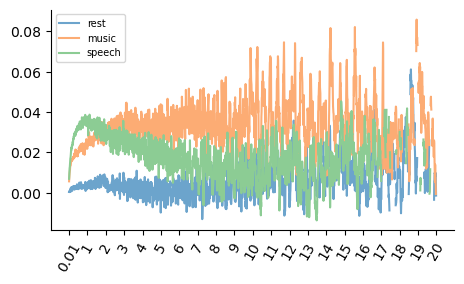

In [24]:
binsizes=np.arange(1, bin_size_max)
max_bin_forplot=2000

plt.figure(figsize=(5,3.2))

bin_rel_corrtoplot={}
for sound in sound_list:
    bin_rel_corrtoplot[sound]=[]

    for bins in binsizes[:max_bin_forplot]:

        bin_rel_corrtoplot[sound].append(real_intersubcorr[bins][sound])

    plt.plot(bin_rel_corrtoplot[sound], color=colors[sound], label=sound)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
xtick=list(np.arange(0,21))
xtick[0]=0.01
plt.xticks(np.arange(0,2001)[::100], xtick , rotation=60) # time in seconds (each time steps, corresponds to 10 s)
plt.tight_layout(pad=2)
plt.savefig('binsizes_effect_max_1000.png', dpi=600)
plt.legend(fontsize=7)
plt.show()
plt.close()

sv.saving(bin_rel_corrtoplot, path_results+'results_Binsizes_mean_corr_dict_toplot')


### Computation of the intersubject correlation for different threshold

In [18]:
th_max=99
th_min=50

ap_th = {}
ap_matrix_th = {}
list_mean_corr_th = {}
z_stats_th={}
real_intersubcorr_th={}
real_intersubcorr_th_std={}
p_value_speech_music_th={}
p_value_speech_rest_th={}
p_value_music_rest_th={}
thresholds = np.arange(th_min,th_max)

In [28]:
for th in thresholds:
    ap_th[th]={} #here the activity profile of each subject is stored

    for subject in subject_list:
        ap_th[th][subject]={}
        avalanches={}
        
        #the threshold is computed as the percentile of interest
        thres=np.percentile(np.abs(zdata[subject]['rest']), th)
        
        for sound in sound_list:
            
            #avalanches dictionaries are computed using the functions of Utils_avalanches.py, with the threshold of interest
            avalanches[sound]=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=2)
            ap_th[th][subject][sound]=np.sum(avalanches[sound]['Zbin'].T, axis=0)

    real_intersubcorr_th[th]={}
    real_intersubcorr_th_std[th]={}
    ap_matrix_th[th]={} 
    for sound in sound_list:
        ap_matrix_th[th][sound]=np.zeros((len(subject_list), len(ap_th[th][subject_list[0]][sound])))
        for isub, subject in enumerate(subject_list):
            ap_matrix_th[th][sound][isub,:]=ap_th[th][subject][sound]
        real_intersubcorr_th[th][sound] = np.mean(np.corrcoef(ap_matrix_th[th][sound])[np.triu_indices(19, k = 1)]) 
        real_intersubcorr_th_std[th][sound]= np.std(np.corrcoef(ap_matrix_th[th][sound])[np.triu_indices(19, k = 1)]) 

    p_value_speech_music_th[th]=stats.wilcoxon(np.corrcoef(ap_matrix_th[th]['speech'])[np.triu_indices(19, k = 1)], np.corrcoef(ap_matrix_th[th]['music'])[np.triu_indices(19, k = 1)])[1]
    p_value_speech_rest_th[th]=stats.wilcoxon(np.corrcoef(ap_matrix_th[th]['speech'])[np.triu_indices(19, k = 1)], np.corrcoef(ap_matrix_th[th]['rest'])[np.triu_indices(19, k = 1)])[1]
    p_value_music_rest_th[th]=stats.wilcoxon(np.corrcoef(ap_matrix_th[th]['music'])[np.triu_indices(19, k = 1)], np.corrcoef(ap_matrix_th[th]['rest'])[np.triu_indices(19, k = 1)])[1]

    

In [29]:
sv.saving(real_intersubcorr_th, path_results+ 'results_mean_corr_dict_th')
sv.saving(real_intersubcorr_th_std,path_results+ 'results_std_corr_dict_th')
sv.saving(p_value_speech_music_th, path_results+'results_p_spmu_dict_th')
sv.saving(p_value_speech_rest_th,path_results+ 'results_p_spre_dict_th')
sv.saving(p_value_music_rest_th, path_results+'results_p_mure_dict_th')

In [30]:
real_intersubcorr_th=sv.loading(path_results+ 'results_mean_corr_dict_th')
real_intersubcorr_th_std=sv.loading(path_results+ 'results_std_corr_dict_th')


### Plotting of the intersubject correlation in function of the threshold

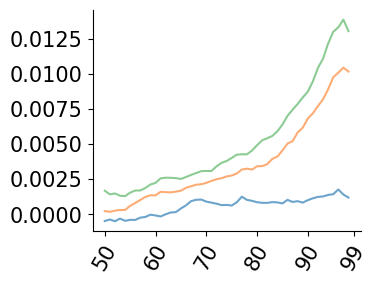

In [39]:
#Here we store the data for the plots.
th_rel_corrtoplot={}
real_intersubcorr_th_std_toplot={} 

plt.figure(figsize=(4,3.2))
for sound in sound_list:
    th_rel_corrtoplot[sound]=[]
    real_intersubcorr_th_std_toplot[sound]=[]
    for th in thresholds:

        th_rel_corrtoplot[sound].append(real_intersubcorr_th[th][sound])
        real_intersubcorr_th_std_toplot[sound].append(real_intersubcorr_th_std[th][sound])
    plt.plot(th_rel_corrtoplot[sound],  color=colors[sound], label=sound)

xticks=list(np.arange(50,99,10))
xticks.append(99)
aa=list(np.arange(0,49,10))
aa.append(49)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(aa, xticks, fontsize=15, rotation=60)
plt.yticks(fontsize=15)
#plt.legend(fontsize=12)
plt.tight_layout(pad=2)
plt.savefig(path_results+'threshold_effect_max.png', dpi=600)
plt.show()
plt.close()

sv.saving(th_rel_corrtoplot, path_results+'results_threshold_mean_corr_dict_toplot')



### Here we compute the intersubject correlation samplig one channel per region

In [6]:
#The main parameter for the computation of these results
n_iteration=1000

zdata={}
real_corr_sim={}

for sound in sound_list:
    real_corr_sim[sound]=list()

for n in range(n_iteration):
    
    for subject in subject_list:
        zdata[subject]={}
        
        for sound in sound_list:
            with h5py.File(pjoin(path+'seeg_data_hgenv_down100_h5py/', subject + '_down100_seeg_preproc.hdf5'), 'r') as f:

                #data_music[subject]=f['music'][...]
                data_raw=f[sound][...]
                
            #Here we delete the time point of the rest that correspond to the end and beginning of the three sessions
            if sound=='rest':
                index_del=np.concatenate((np.arange(int(len(data_raw[0,:])/3)-200,int(len(data_raw[0,:])/3)+200),np.arange(int(len(data_raw[0,:])*2/3)-200,int(len(data_raw[0,:])*2/3)+200)))   
                data_raw=np.delete(data_raw, index_del, axis=1)

            data_raw=data_raw[:,100:-100]

            #Here we load the channels names
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']

            #Here we load the list of bad channels
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:

                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

            #here we store the indices of the bad channels
            ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

            #Here we stored the name of the "good" channels
            clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]

            #here we reupload the channel names list and the region of the atlass that we consider
            with h5py.File(pjoin(path+'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                
                chnames = f['chnames'][...].astype('U')
                at=f['atlasses']['Brainnetome'][...]
            
            #Here we create the list of indices that we want to consider
            listR=[a[:13] for a in at]#list of channels by the name of the regions in which they belong
            list_goodR=np.delete(listR, ch_i)#list of good channels by the name of the region in which they belong
            setR=list(dict.fromkeys(list_goodR))
            good_indices=[]
            
            for i in setR:
                
                #For each region we select only 1 index
                indices=[j for j, r in enumerate(list_goodR) if r==i]
                good_indices.append(np.random.choice(indices))

            
            clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
            ch_i_sim = [i for i, ch in enumerate(clean_chnames) if i not in good_indices]#here we store the indices of this iteration
            clean_chnames_sim= [ch for i, ch in enumerate(clean_chnames) if i in good_indices]
            
            clea = np.delete(data_raw, ch_i, axis=0)#clean data
            clean= np.delete(clea,  ch_i_sim, axis=0)#clean data, only channels for the iteration

            #The final channels that we used
            final_channels=clean_chnames_sim

            #zscore of the data
            zdata_art=stats.zscore(clean, axis=1)

            #the artifacts are substituted by 0
            zdata_=np.where(np.abs(zdata_art)>5, 0, zdata_art)

            #zscored computed again
            zdata[subject][sound]=stats.zscore(zdata_, axis=1)
    
    ap={} #here the activity profile of each subject is stored

    for subject in subject_list:
        ap[subject]={}
        avalanches={}
        
        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata[subject]['rest'], 99)
        
        for sound in sound_list:
            
            #avalanches dictionaries are computed using the functions of Utils_avalanches.py
            avalanches[sound]=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=2)
            ap[subject][sound]=np.sum(avalanches[sound]['Zbin'].T, axis=0)
            
    ap_matrix={} 
    for sound in sound_list:
        ap_matrix[sound]=np.zeros((len(subject_list), len(ap[subject_list[0]][sound])))
        for isub, subject in enumerate(subject_list):
            ap_matrix[sound][isub,:]=ap[subject][sound] 

    #Finally we append to the list the result of this random iteration.
    for sound in sound_list:
        real_corr_sim[sound].append(np.mean(np.corrcoef(ap_matrix[sound])[np.triu_indices(19, k = 1)]))

#For comodity we store the results as an array
for sound in sound_list:
    real_corr_sim[sound]= np.array(real_corr_sim[sound])

       

Saving the results:

In [7]:
sv.saving(real_corr_sim,path_results+'results_sim_random_picking_1perregion')

In [7]:
real_corr_sim = sv.loading(path_results+'results_sim_random_picking_1perregion')

4.191713056722473e-52
0.0
0.0
TtestResult(statistic=15.640089818430665, pvalue=4.191713056722473e-52, df=1998.0)
TtestResult(statistic=75.03791485574202, pvalue=0.0, df=1998.0)
TtestResult(statistic=55.4147364463544, pvalue=0.0, df=1998.0)


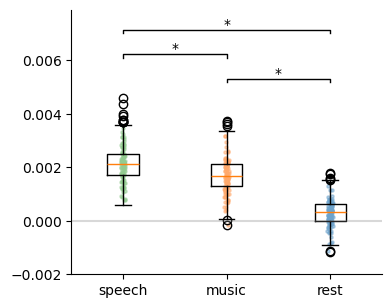

In [8]:

C1 = {'s': '#93cb90', 'm': '#ffa96b', 'r': '#6da3cc'}

plt.figure(figsize=(3.7,3))
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

dist_sp_re1=real_corr_sim['speech']
dist_re_mu1=real_corr_sim['music']
dist_sp_mu1=real_corr_sim['rest']

#plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[dist_sp_re1,dist_re_mu1,dist_sp_mu1]#[left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']]
for i in np.arange(len(dist_sp_mu1))[::10]:
    spmu=dist_sp_mu1[i]
    remu=dist_re_mu1[i]
    spre=dist_sp_re1[i]
    eps1=(np.random.rand()-.5)*((1-spre*100))*0.05
    eps2=(np.random.rand()-.5)*((1-remu*100))*0.05
    eps3=(np.random.rand()-.5)*((1-spmu*100))*0.05
    plt.scatter(1+eps1,spre,color=C1['s'],alpha=.5, s=5)#color=C2['sr']
    plt.scatter(2+eps2,remu,color=C1['m'],alpha=.5, s=5)#color=C2['mr'],
    plt.scatter(3+eps3,spmu,color=C1['r'],alpha=.5, s=5)#color=C2['sm']

    # plt.scatter(1,spre,color=C1['s'],alpha=.5)
    # plt.scatter(2,remu,color=C1['m'],alpha=.5)
    # plt.scatter(3,spmu,color=C1['m'],alpha=.9)
    # plt.scatter(1,spre,color=C1['r'],alpha=.5)
    # plt.scatter(2,remu,color=C1['r'],alpha=.5)
    # plt.scatter(3,spmu,color=C1['s'],alpha=.5)
    '''if spre-remu<0:
        plt.plot([1,2],[spre,remu],color='grey',alpha=0.4)
    else:
        plt.plot([1,2],[spre,remu],color='grey',alpha=0.4,linestyle='--')

    if spmu-remu<0:
        plt.plot([3,2],[spmu,remu],color='grey',alpha=0.4)
    else:
        plt.plot([3,2],[spmu,remu],color='grey',alpha=0.4,linestyle='--')'''

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music','rest'])
psrmr=stats.ttest_ind(dist_sp_re1,dist_re_mu1)[1]
psrsm=stats.ttest_ind(dist_sp_re1,dist_sp_mu1)[1]
pmrsm=stats.ttest_ind(dist_re_mu1,dist_sp_mu1)[1]

print(psrmr)
print(psrsm)
print(pmrsm)
print(stats.ttest_ind(dist_sp_re1,dist_re_mu1))
print(stats.ttest_ind(dist_sp_re1,dist_sp_mu1))
print(stats.ttest_ind(dist_re_mu1,dist_sp_mu1))

# p=Gtest(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'])
# print('Gio test  ', p)
# print(stats.wilcoxon(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']))
# print('p_value music - speech ', pp)
# print('p_value music - rest ', psr)
# print('p_value music - rest ', pmr)

to_min1=np.array([dist_sp_re1,dist_re_mu1,dist_sp_mu1])
bottom1, top1 = np.min(to_min1), np.max(to_min1)
bars_diff(psrmr, bottom1, top1,height=3.5)
bars_diff(psrsm, bottom1, top1,x1=1,x2=3,height=5.5)
bars_diff(pmrsm, bottom1, top1,x1=2,x2=3,height=1.5)
plt.tight_layout(pad=0.35)
plt.axhline(0, color='grey', alpha = 0.3)
plt.ylim((-0.002,0.0079))

plt.savefig(path_results+'one_ch_per_reg_intersub_corr_reali.png', dpi=600)
# plt.show()
# plt.close()


## p values computations


In [9]:
for sound in sound_list:
    p=np.sum(np.where((real_corr_sim[sound]) < 0, 1,0))/1000
    print(p,sound)

0.248 rest
0.001 music
0.0 speech
